# Visualization Variant Painting Images and Cells

In [4]:
import os
import glob
import polars as pl
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.io import imread
from tqdm import tqdm
import re
import sys
import subprocess
from plot_utils import *

PLATEMAP_DIR = "../2.snakemake_pipeline/inputs/metadata/platemaps/{batch_id}/platemap"
TIFF_IMGS_DIR = "../1.image_preprocess_qc/inputs/cpg_imgs"
IMG_QC_DIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/1.image_qc_outputs/{bio_rep}"

## 1. Loading meta data and variant classification

In [6]:
BIO_REP_BATCHES_DICT = {
    "2024_01_Batch_7-8": ("2024_01_23_Batch_7", "2024_02_06_Batch_8"),
    "2024_12_Batch_11-12": ("2024_12_09_Batch_11", "2024_12_09_Batch_12"),
    "2025_03_Batch_15-16": ("2025_03_17_Batch_15", "2025_03_17_Batch_16"),
    # "2025_01_Batch_13-14": ("2025_01_27_Batch_13", "2025_01_28_Batch_14")
}

BIO_BATCH_MAP_DICT = {
    "B7": "B_7-8",
    "B8": "B_7-8",
    "B11": "B_11-12",
    "B12": "B_11-12",
    "B15": "B_15-16",
    "B16": "B_15-16",
}

FEAT_SETS = ["DNA", "Mito", "GFP", "AGP", "Morph"]
OUT_IMG_DIR = f"../2.snakemake_pipeline/outputs/visualize_imgs"
OUT_CELL_DIR = f"../2.snakemake_pipeline/outputs/visualize_cells"
CLASS_RES_OUTDIR = "../../../../3_outputs/1_snakemake_pipeline/2.smp_results_analyses/3.classification_results"

### 1.1 Read in the meta data

In [7]:
allele_meta_df, img_well_qc_sum_df = pl.DataFrame(), pl.DataFrame()
allele_meta_df_dict, img_well_qc_sum_dict, auroc_df_dict = {}, {}, {}

for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df_batch = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df_batch = pl.concat([allele_meta_df_batch, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df_batch = allele_meta_df_batch.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
        allele_meta_df = pl.concat([
            allele_meta_df,
            allele_meta_df_batch
        ], how="diagonal_relaxed")#.sort("plate_map_name") ## (~pl.col("node_type").is_in(["TC","NC","PC"]))&
    allele_meta_df_dict[bio_rep] = allele_meta_df_batch

    img_well_qc_sum = pl.read_csv(f"{IMG_QC_DIR.format(bio_rep=bio_rep)}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum_morph = img_well_qc_sum.filter(pl.col("channel")!="GFP")
    img_well_qc_sum_morph = img_well_qc_sum_morph.group_by(["plate","well"]).agg(
        pl.col("is_bg").max().alias("is_bg"),
        pl.col("s2n_ratio").mean().alias("s2n_ratio"),
        pl.col("median_plate").mean().alias("median_plate"),
    ).with_columns(pl.lit("Morph").alias("channel"))
    img_well_qc_sum = pl.concat([
        img_well_qc_sum.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
        img_well_qc_sum_morph.select(pl.col(["plate","well","channel","median_plate","is_bg","s2n_ratio"])),
    ], how="vertical_relaxed")
    
    img_well_qc_sum_df = pl.concat(
        [img_well_qc_sum_df, img_well_qc_sum],
        how="diagonal_relaxed"
    )
    img_well_qc_sum_dict[bio_rep] = img_well_qc_sum

    auroc_df_dict[bio_rep] = {}
    for feat in FEAT_SETS:
        auroc_df = pl.read_csv(f"{CLASS_RES_OUTDIR}/{bio_rep}/altered_{feat}_summary_auroc.csv")
        auroc_df_dict[bio_rep][feat] = auroc_df

In [9]:
auroc_df_dict["2024_01_Batch_7-8"]["GFP"].filter(pl.col("Altered_GFP_99_both_batches"))

shape: (15, 10)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ allele_0  ┆ Altered_G ┆ Altered_G ┆ Altered_G ┆ … ┆ Altered_G ┆ AUROC_bat ┆ AUROC_bat ┆ AUROC_Me │
│ ---       ┆ FP_95_bat ┆ FP_95_bat ┆ FP_95_bot ┆   ┆ FP_99_bot ┆ ch8       ┆ ch7       ┆ an       │
│ str       ┆ ch8       ┆ ch7       ┆ h_batches ┆   ┆ h_batches ┆ ---       ┆ ---       ┆ ---      │
│           ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ f64       ┆ f64       ┆ f64      │
│           ┆ i64       ┆ i64       ┆ bool      ┆   ┆ bool      ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ TAT_Arg11 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.992994  ┆ 0.997814  ┆ 0.995404 │
│ 9Trp      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ SMAD1_Val ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.995299  ┆ 0.99416   ┆ 0.994729 │
│ 3Ala      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ HPRT1_Leu ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.993009  ┆ 0.996809  ┆ 0.994909 │
│ 41Pro     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PMP22_Cys ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.999451  ┆ 0.999744  ┆ 0.999598 │
│ 109Arg    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ TAT_Leu27 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.992311  ┆ 0.997175  ┆ 0.994743 │
│ 3Pro      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ RP2_Arg11 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.990423  ┆ 0.995634  ┆ 0.993029 │
│ 8Leu      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ FXN_Met1I ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.994864  ┆ 0.997148  ┆ 0.996006 │
│ le        ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ DCX_Ser12 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.99014   ┆ 0.996964  ┆ 0.993552 │
│ 9Leu      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ PMP22_Leu ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.997455  ┆ 0.999002  ┆ 0.998229 │
│ 80Pro     ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ RP2_Leu25 ┆ 1         ┆ 1         ┆ true      ┆ … ┆ true      ┆ 0.996596  ┆ 0.994385  ┆ 0.99549  │
│ 3Arg      ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

## 2. Plot Variant Painting Well Images

In [13]:
bio_rep, feat = "2024_01_Batch_7-8", "GFP"
out_batch_img_dir = f"{OUT_IMG_DIR}/{bio_rep}"
os.makedirs(out_batch_img_dir)

<Figure size 640x480 with 0 Axes>

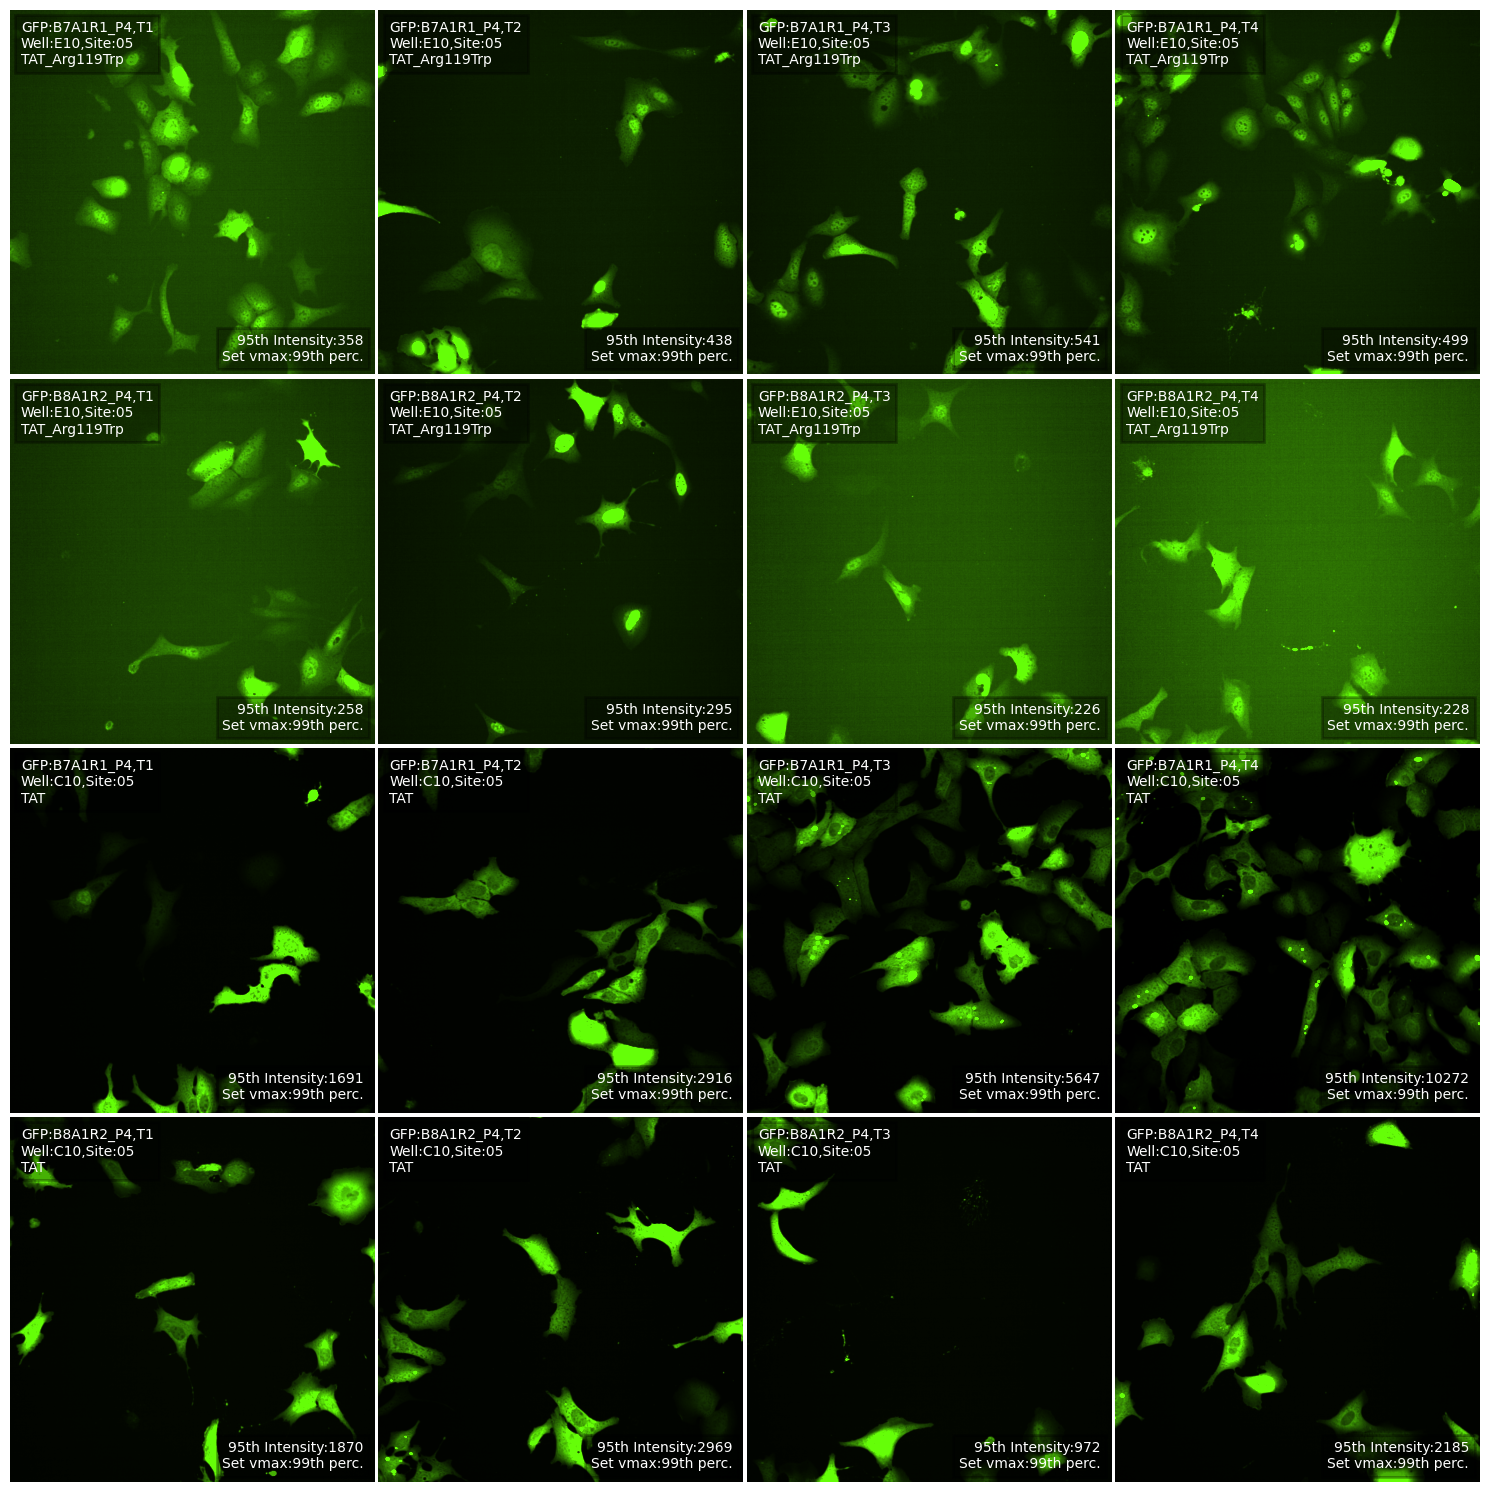

In [14]:
plot_allele(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
            variant="TAT_Arg119Trp", sel_channel=feat, 
            auroc_df=auroc_df_dict[bio_rep][feat], 
            plate_img_qc=img_well_qc_sum_dict[bio_rep], 
            site="05", max_intensity=0.99, display=True, 
            imgs_dir=TIFF_IMGS_DIR, output_dir=out_batch_img_dir)

<Figure size 640x480 with 0 Axes>

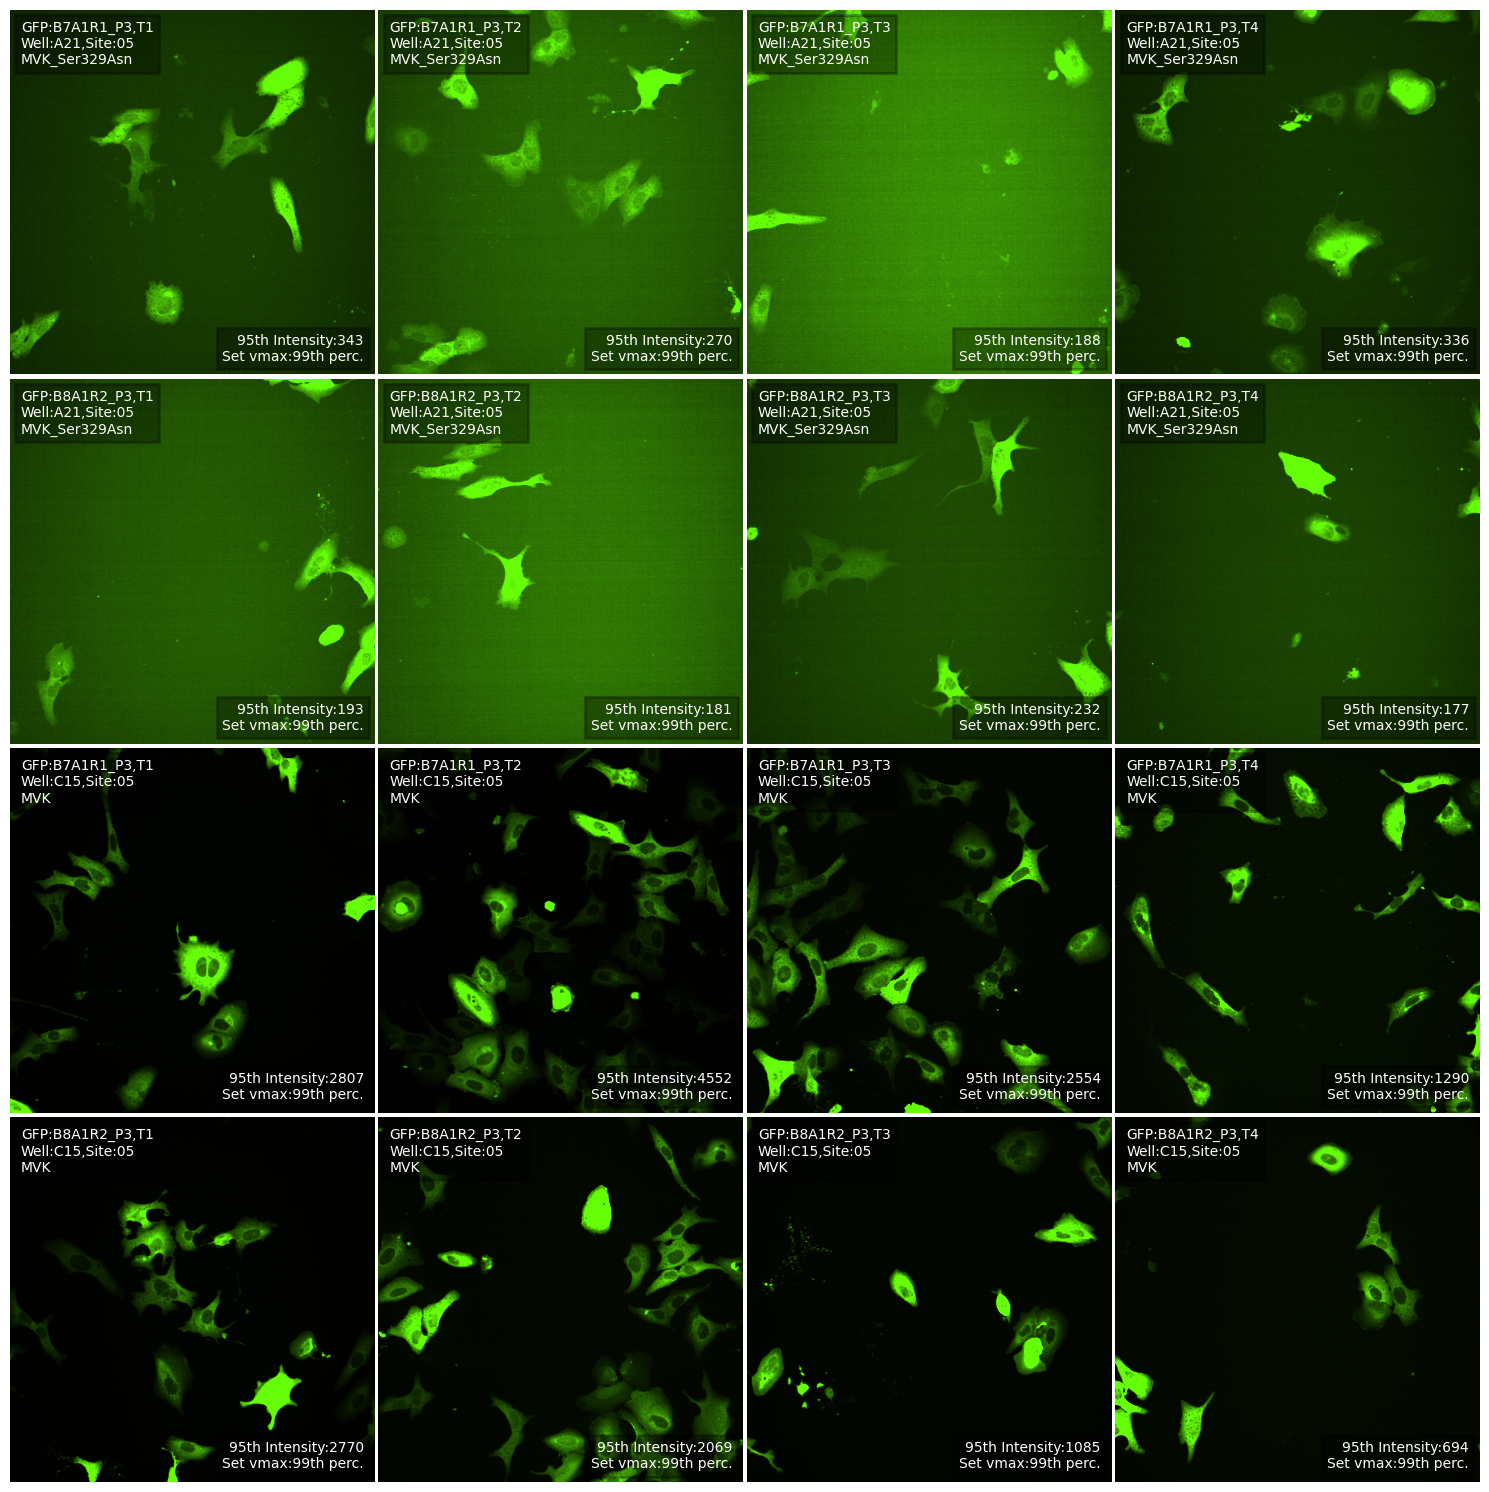

In [19]:
plot_allele(allele_meta_df_dict[bio_rep], ##.filter(pl.col("plate_map_name").str.contains("B13")
            variant="MVK_Ser329Asn", sel_channel=feat, 
            auroc_df=auroc_df_dict[bio_rep][feat], 
            plate_img_qc=img_well_qc_sum_dict[bio_rep], 
            site="05", max_intensity=0.99, display=True, 
            imgs_dir=TIFF_IMGS_DIR, output_dir=out_batch_img_dir)

## 3. Plot Cells

In [15]:
BATCH_PROFILES = "../2.snakemake_pipeline/outputs/batch_profiles/{}/profiles.parquet" 
IMG_ANALYSIS_DIR = "../1.image_preprocess_qc/inputs/cpg_imgs/{}/analysis"

In [18]:
# Filter thresholds
min_area_ratio = 0.15
max_area_ratio = 0.3
min_center = 50
max_center = 1030

# num_mad = 5
# min_cells = 250

batch_profiles = {}
for batch_id in BIO_REP_BATCHES_DICT[bio_rep]:
    imagecsv_dir = IMG_ANALYSIS_DIR.format(batch_id) #f"../../../8.1_upstream_analysis_runxi/2.raw_img_qc/inputs/images/{batch_id}/analysis"
    prof_path = BATCH_PROFILES.format(batch_id)
    # Get metadata
    profiles = pl.scan_parquet(prof_path).select(
        ["Metadata_well_position", "Metadata_plate_map_name", "Metadata_ImageNumber", "Metadata_ObjectNumber",
        "Metadata_symbol", "Metadata_gene_allele", "Metadata_node_type", "Metadata_Plate",
        "Nuclei_AreaShape_Area", "Cells_AreaShape_Area", "Nuclei_AreaShape_Center_X", "Nuclei_AreaShape_Center_Y",
        "Cells_AreaShape_BoundingBoxMaximum_X", "Cells_AreaShape_BoundingBoxMaximum_Y", "Cells_AreaShape_BoundingBoxMinimum_X",
        "Cells_AreaShape_BoundingBoxMinimum_Y",	"Cells_AreaShape_Center_X",	"Cells_AreaShape_Center_Y",
        "Cells_Intensity_MeanIntensity_GFP", "Cells_Intensity_MedianIntensity_GFP", "Cells_Intensity_IntegratedIntensity_GFP"],
    ).collect()
    # print(profiles["Metadata_Plate"])
    # break

    # Filter based on cell to nucleus area
    profiles = profiles.with_columns(
                    (pl.col("Nuclei_AreaShape_Area")/pl.col("Cells_AreaShape_Area")).alias("Nucleus_Cell_Area"),
                    pl.concat_str([
                        "Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber", "Metadata_ObjectNumber",
                        ], separator="_").alias("Metadata_CellID"),
            ).filter((pl.col("Nucleus_Cell_Area") > min_area_ratio) & (pl.col("Nucleus_Cell_Area") < max_area_ratio))

    # Filter cells too close to image edge
    profiles = profiles.filter(
        ((pl.col("Nuclei_AreaShape_Center_X") > min_center) & (pl.col("Nuclei_AreaShape_Center_X") < max_center) &
        (pl.col("Nuclei_AreaShape_Center_Y") > min_center) & (pl.col("Nuclei_AreaShape_Center_Y") < max_center)),
    )

    # Calculate mean, median and mad of gfp intensity for each allele
    ## mean
    means = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MeanIntensity_GFP").mean().alias("WellIntensityMean"),
    )
    profiles = profiles.join(means, on=["Metadata_Plate", "Metadata_well_position"])
    ## median
    medians = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Cells_Intensity_MedianIntensity_GFP").median().alias("WellIntensityMedian"),
    )
    profiles = profiles.join(medians, on=["Metadata_Plate", "Metadata_well_position"])
    ## mad
    profiles = profiles.with_columns(
        (pl.col("Cells_Intensity_MedianIntensity_GFP") - pl.col("WellIntensityMedian")).abs().alias("Abs_dev"),
    )
    mad = profiles.group_by(["Metadata_Plate", "Metadata_well_position"]).agg(
        pl.col("Abs_dev").median().alias("Intensity_MAD"),
    )
    profiles = profiles.join(mad, on=["Metadata_Plate", "Metadata_well_position"])

    # Threshold is 5X
    # Used to be median well intensity + 5*mad implemented by Jess
    # Switching to mean well intensity + 5*mad implemented by Runxi
    # profiles = profiles.with_columns(
    #     (pl.col("WellIntensityMedian") + num_mad*pl.col("Intensity_MAD")).alias("Intensity_upper_threshold"), ## pl.col("WellIntensityMedian")
    #     (pl.col("WellIntensityMedian") - num_mad*pl.col("Intensity_MAD")).alias("Intensity_lower_threshold"), ## pl.col("WellIntensityMedian")
    # )
    # ## Filter by intensity MAD
    # profiles = profiles.filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") <= pl.col("Intensity_upper_threshold"),
    # ).filter(
    #     pl.col("Cells_Intensity_MeanIntensity_GFP") >= pl.col("Intensity_lower_threshold"),
    # )

    # Filter out alleles with fewer than 250 cells
    # keep_alleles = profiles.group_by("Metadata_gene_allele").count().filter(
    #     pl.col("count") >= min_cells,
    #     ).select("Metadata_gene_allele").to_series().to_list()
    # profiles = profiles.filter(pl.col("Metadata_gene_allele").is_in(keep_alleles))

    # add full crop coordinates
    profiles = profiles.with_columns(
        (pl.col("Nuclei_AreaShape_Center_X") - 50).alias("x_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_X") + 50).alias("x_high").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") - 50).alias("y_low").round().cast(pl.Int16),
        (pl.col("Nuclei_AreaShape_Center_Y") + 50).alias("y_high").round().cast(pl.Int16),
    )

    # Read in all Image.csv to get ImageNumber:SiteNumber mapping and paths
    image_dat = []
    icfs = glob.glob(os.path.join(imagecsv_dir, "**/*Image.csv"), recursive=True)
    for icf in tqdm(icfs):
        fp = icf.split('/')[-2]
        # print(fp)
        plate, well = "-".join(fp.split("-")[:-2]), fp.split("-")[-2]
        # print(plate, well)
        image_dat.append(pl.read_csv(icf).select(
            [
                "ImageNumber",
                "Metadata_Site",
                "PathName_OrigDNA",
                "FileName_OrigDNA",
                "FileName_OrigGFP",
                ],
            ).with_columns(
            pl.lit(plate).alias("Metadata_Plate"),
            pl.lit(well).alias("Metadata_well_position"),
            ))
    image_dat = pl.concat(image_dat).rename({"ImageNumber": "Metadata_ImageNumber"})

    # Create useful filepaths
    image_dat = image_dat.with_columns(
        pl.col("PathName_OrigDNA").str.replace(".*cpg0020-varchamp/", "").alias("Path_root"),
    )

    image_dat = image_dat.drop([
        "PathName_OrigDNA",
        "FileName_OrigDNA",
        "FileName_OrigGFP",
        "Path_root",
    ])
    # print(image_dat)

    # Append to profiles
    profiles = profiles.join(image_dat, on = ["Metadata_Plate", "Metadata_well_position", "Metadata_ImageNumber"])

    # Sort by allele, then image number
    profiles = profiles.with_columns(
        pl.concat_str(["Metadata_Plate", "Metadata_well_position", "Metadata_Site"], separator="_").alias("Metadata_SiteID"),
        pl.col("Metadata_gene_allele").str.replace("_", "-").alias("Protein_label"),
    )
    profiles = profiles.sort(["Protein_label", "Metadata_SiteID"])
    alleles = profiles.select("Protein_label").to_series().unique().to_list()

    batch_profiles[batch_id] = profiles

100%|██████████| 69004/69004 [04:21<00:00, 263.98it/s]


In [68]:
def crop_allele(allele: str, profile_df: pl.DataFrame, meta_plate: str, rep: str, site: str="5") -> None:
    """Crop images and save metadata as numpy arrays for one allele.

    Parameters
    ----------
    allele : String
        Name of allele to process
    profile_df : String
        Dataframe with pathname and cell coordinates
    img_dir : String
        Directory where all images are stored
    out_dir : String
        Directory where numpy arrays should be saved
    """
    allele_df = profile_df.filter(
        (pl.col("Metadata_gene_allele")==allele) &
        (pl.col("Metadata_Site")==int(site)) &
        (pl.col("Metadata_plate_map_name").str.contains(meta_plate)) &
        (pl.col("Metadata_Plate").str.contains(rep))
    )
    return allele_df


# Compute distances from edges and find the most centered well
def compute_distance_cell(row, col, edge=1080):
    return min(row - 1, edge - row, col - 1, edge - col)  # Distance from nearest edge


allele_df = crop_allele("MVK", batch_profiles["2024_02_06_Batch_8"], "B8A1R2", "T2", site="5")
allele_df

shape: (0, 34)
┌────────────┬────────────┬───────────┬───────────┬───┬────────┬───────────┬───────────┬───────────┐
│ Metadata_w ┆ Metadata_p ┆ Metadata_ ┆ Metadata_ ┆ … ┆ y_high ┆ Metadata_ ┆ Metadata_ ┆ Protein_l │
│ ell_positi ┆ late_map_n ┆ ImageNumb ┆ ObjectNum ┆   ┆ ---    ┆ Site      ┆ SiteID    ┆ abel      │
│ on         ┆ ame        ┆ er        ┆ ber       ┆   ┆ i16    ┆ ---       ┆ ---       ┆ ---       │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆        ┆ i64       ┆ str       ┆ str       │
│ str        ┆ str        ┆ i64       ┆ i64       ┆   ┆        ┆           ┆           ┆           │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪════════╪═══════════╪═══════════╪═══════════╡
└────────────┴────────────┴───────────┴───────────┴───┴────────┴───────────┴───────────┴───────────┘

In [70]:
def plot_allele_cell(pm, variant, sel_channel, auroc_df, plate_img_qc, site="05", max_intensity=0.99, display=False, imgs_dir=TIFF_IMGS_DIR, output_dir=""):
    cmap = channel_to_cmap(sel_channel)
    channel = channel_dict[sel_channel]
    auroc = auroc_df.filter(pl.col("allele_0")==variant)["AUROC_Mean"].mean()

    # if os.path.exists(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png")):
    #     print(f"Image for {variant} already exists.")
        # return None

    ## get the number of wells/images per allele
    wt = variant.split("_")[0]
    wt_wells = pm.filter(pl.col("gene_allele") == wt).select("imaging_well").to_pandas().values.flatten()
    var_wells = pm.filter(pl.col("gene_allele") == variant).select("imaging_well").to_pandas().values.flatten()
    plate_map = pm.filter(pl.col("gene_allele") == variant).select("plate_map_name").to_pandas().values.flatten()

    if len(wt_wells) > 1:
        # Get coordinates of wells
        well_coords = [well_to_coordinates(w) for w in set([ref_well_pl for ref_well_pl in wt_wells])]
        # Sort wells by max distance from edges (descending)
        wt_wells = [max(well_coords, key=lambda x: compute_distance(x[1], x[2]))[0]]

    pm_var = pm.filter((pl.col("imaging_well").is_in(np.concatenate([wt_wells, var_wells])))&(pl.col("plate_map_name").is_in(plate_map))).sort("node_type")
    # print(pm_var)
    plt.clf()

    fig, axes = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    # fig2, axes2 = plt.subplots((len(wt_wells)+len(var_wells))*2, 4, figsize=(15, 16), sharex=True, sharey=True)
    for wt_var, pm_row in enumerate(pm_var.iter_rows(named=True)):
        # print(pm_row)
        if pm_row["node_type"] == "allele":
            well = var_wells[0]
            allele = variant
        else:
            well = wt_wells[0]
            allele = wt

        for i in range(8):
            plot_idx = i+wt_var*4*2
            if i < 4:
                sel_plate = pm_row["imaging_plate_R1"]
            else:
                sel_plate = pm_row["imaging_plate_R2"]
                
            batch = batch_dict[sel_plate.split("_")[0]]
            batch_img_dir = f'{imgs_dir}/{batch}/images'
            letter = well[0]
            row = letter_dict[letter]
            col = well[1:3]
            
            # print(i, allele, well)
            plate_img_dir = plate_dict[sel_plate][f"T{i%4+1}"]
            img_file = f"r{row}c{col}f{site}p01-ch{channel}sk1fk1fl1.tiff"
            img = imread(f"{batch_img_dir}/{plate_img_dir}/Images/{img_file}", as_gray=True)
            # print(np.percentile(img, 99) / np.median(img), np.percentile(img, 99) / np.percentile(img, 25))
            if plate_img_qc is not None:
                is_bg = plate_img_qc.filter((pl.col("plate") == plate_img_dir.split("__")[0]) & (pl.col("well") == well) & (pl.col("channel") == sel_channel))["is_bg"].to_numpy()[0]
                
            ## Full images
            # axes2.flatten()[plot_idx].imshow(img, vmin=0, vmax=np.percentile(img, max_intensity*100), cmap=cmap)
            # plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
            # axes2.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
            #         verticalalignment='top', horizontalalignment='left', transform=axes2.flatten()[plot_idx].transAxes,
            #         bbox=dict(facecolor='black', alpha=0.3, linewidth=2))

            ## Draw cells
            cell_allele_coord_df = crop_allele(allele, batch_profiles[batch], sel_plate.split("P")[0], f"T{i%4+1}", site=site[-1])
            # if (cell_allele_coord_df.is_empty()):
            #     print(batch, allele, sel_plate, f"T{i%4+1}")
            #     print(cell_allele_coord_df)            
            cell_allele_coord_df = cell_allele_coord_df.with_columns(
                pl.struct("Cells_AreaShape_Center_X", "Cells_AreaShape_Center_Y") # 'Nuclei_AreaShape_Center_X', 'Nuclei_AreaShape_Center_Y'
                .map_elements(lambda x: compute_distance_cell(x['Cells_AreaShape_Center_X'], x['Cells_AreaShape_Center_Y']), return_dtype=pl.Float32).cast(pl.Int16)
                .alias('dist2edge')
            ).sort(by=["dist2edge","Cells_AreaShape_Area"], descending=[True,True]).filter(pl.col("Cells_AreaShape_Area")>5000)

            if cell_allele_coord_df.is_empty():
                axes.flatten()[plot_idx].text(0.97, 0.97, "No high-quality\ncell available", color='black', fontsize=12,
                    verticalalignment='top', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                    bbox=dict(facecolor='white', alpha=0.3, linewidth=2)
                )
                # axes.flatten()[plot_idx].set_visible(False)
                x, y = img.shape[0] // 2, img.shape[1] // 2
                img_sub = img[
                    y-112:y+112, x-112:x+112
                ]
                axes.flatten()[plot_idx].imshow(img_sub, vmin=0, vmax=np.percentile(img_sub, max_intensity*100), cmap=cmap)  ## np.percentile(img_sub, max_intensity*100)
            else:
                plot_yet = 0
                flag = False
                for cell_idx, cell_row in enumerate(cell_allele_coord_df.head(10).iter_rows(named=True)):
                    if plot_yet:
                        break
                    x, y = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
                    # x, y = int(cell_allele_coord_df["Cells_AreaShape_Center_X"].to_numpy()[0]), int(cell_allele_coord_df["Cells_AreaShape_Center_Y"].to_numpy()[0])
                    ## flip the x and y for visualization
                    img_sub = img[
                        y-112:y+112, x-112:x+112
                    ]
                    ## skip the subimage due to poor cell quality
                    if img_sub.shape[0] == 0 or img_sub.shape[1] == 0 or np.percentile(img_sub, 90) <= np.median(img) or np.var(img_sub) < 1e4:
                        flag = True
                    axes.flatten()[plot_idx].imshow(img_sub, vmin=0, vmax=np.percentile(img_sub, max_intensity*100), cmap=cmap)  ## np.percentile(img_sub, max_intensity*100)
                    plot_label = f"{sel_channel}:{sel_plate},T{i%4+1}\nWell:{well},Site:{site}\n{allele}"
                    axes.flatten()[plot_idx].text(0.03, 0.97, plot_label, color='white', fontsize=10,
                            verticalalignment='top', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                            bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    if is_bg:
                        axes.flatten()[plot_idx].text(0.03, 0.03, "FLAG:\nOnly Background\nNoise is Detected", color='red', fontsize=10,
                            verticalalignment='bottom', horizontalalignment='left', transform=axes.flatten()[plot_idx].transAxes,
                            bbox=dict(facecolor='white', alpha=0.3, linewidth=2))
                    if flag:
                        axes.flatten()[plot_idx].text(0.97, 0.97, "Poor Quality FLAG", color='red', fontsize=10,
                            verticalalignment='top', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                            bbox=dict(facecolor='white', alpha=0.3, linewidth=2))
                    int_95 = str(int(round(np.percentile(img_sub, 95))))
                    axes.flatten()[plot_idx].text(0.95, 0.05, f"95th Intensity:{int_95}", color='white', fontsize=10,
                                verticalalignment='bottom', horizontalalignment='right', transform=axes.flatten()[plot_idx].transAxes,
                                bbox=dict(facecolor='black', alpha=0.3, linewidth=2))
                    plot_yet = 1
                    
            axes.flatten()[plot_idx].axis("off")
                # axes.flatten()[plot_idx].set_visible(False)
                # x_min, y_min, x_max, y_max = int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMinimum_Y"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_X"].to_numpy()[0]), \
                #                              int(cell_allele_coord_df["Cells_AreaShape_BoundingBoxMaximum_Y"].to_numpy()[0])
                # print(x_min, y_min, x_max, y_max)
            #     for cell_idx, cell_row in enumerate(cell_allele_coord_df.head().iter_rows(named=True)):
            #         x_nuc, y_nuc = int(cell_row["Nuclei_AreaShape_Center_X"]), int(cell_row["Nuclei_AreaShape_Center_Y"])
            #         # Create a Rectangle patch
            #         rect = patches.Rectangle((x_nuc-5, y_nuc-5), 10, 10, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         rect = patches.Rectangle((x-128, y-128), 256, 256, linewidth=2, edgecolor='red', facecolor='none')
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         # x_min, y_min, x_max, y_max = int(cell_row["Cells_AreaShape_BoundingBoxMinimum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMinimum_Y"]), \
            #         #                              int(cell_row["Cells_AreaShape_BoundingBoxMaximum_X"]), int(cell_row["Cells_AreaShape_BoundingBoxMaximum_Y"])
            #         # print(x_min, y_min, x_max, y_max)
            #         # rect = patches.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=2, edgecolor='red', facecolor='none')
            #         # Add the patch to the Axes
            #         axes2.flatten()[plot_idx].add_patch(rect)
            #         break
            # int_95 = str(int(round(np.percentile(img, 95))))
            # axes2.flatten()[plot_idx].axhline(y=img.shape[1]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].axvline(x=img.shape[0]//2, color='red', linestyle='--', linewidth=1)
            # axes2.flatten()[plot_idx].text(0.95, 0.05, f"95th Percentile\nIntensity:{int_95}", color='white', fontsize=12,
            #                verticalalignment='bottom', horizontalalignment='right', transform=axes2.flatten()[plot_idx].transAxes)
            # axes2.flatten()[plot_idx].axis("off")
            
    fig.tight_layout()
    fig.subplots_adjust(wspace=.01, hspace=-0.2, top=.99)
    
    if display:
        plt.show()

    if output_dir:
        fig.savefig(os.path.join(output_dir, f"{variant}_{sel_channel}_{auroc:.3f}_cells.png"), dpi=400, bbox_inches='tight')
        plt.close(fig)

<Figure size 640x480 with 0 Axes>

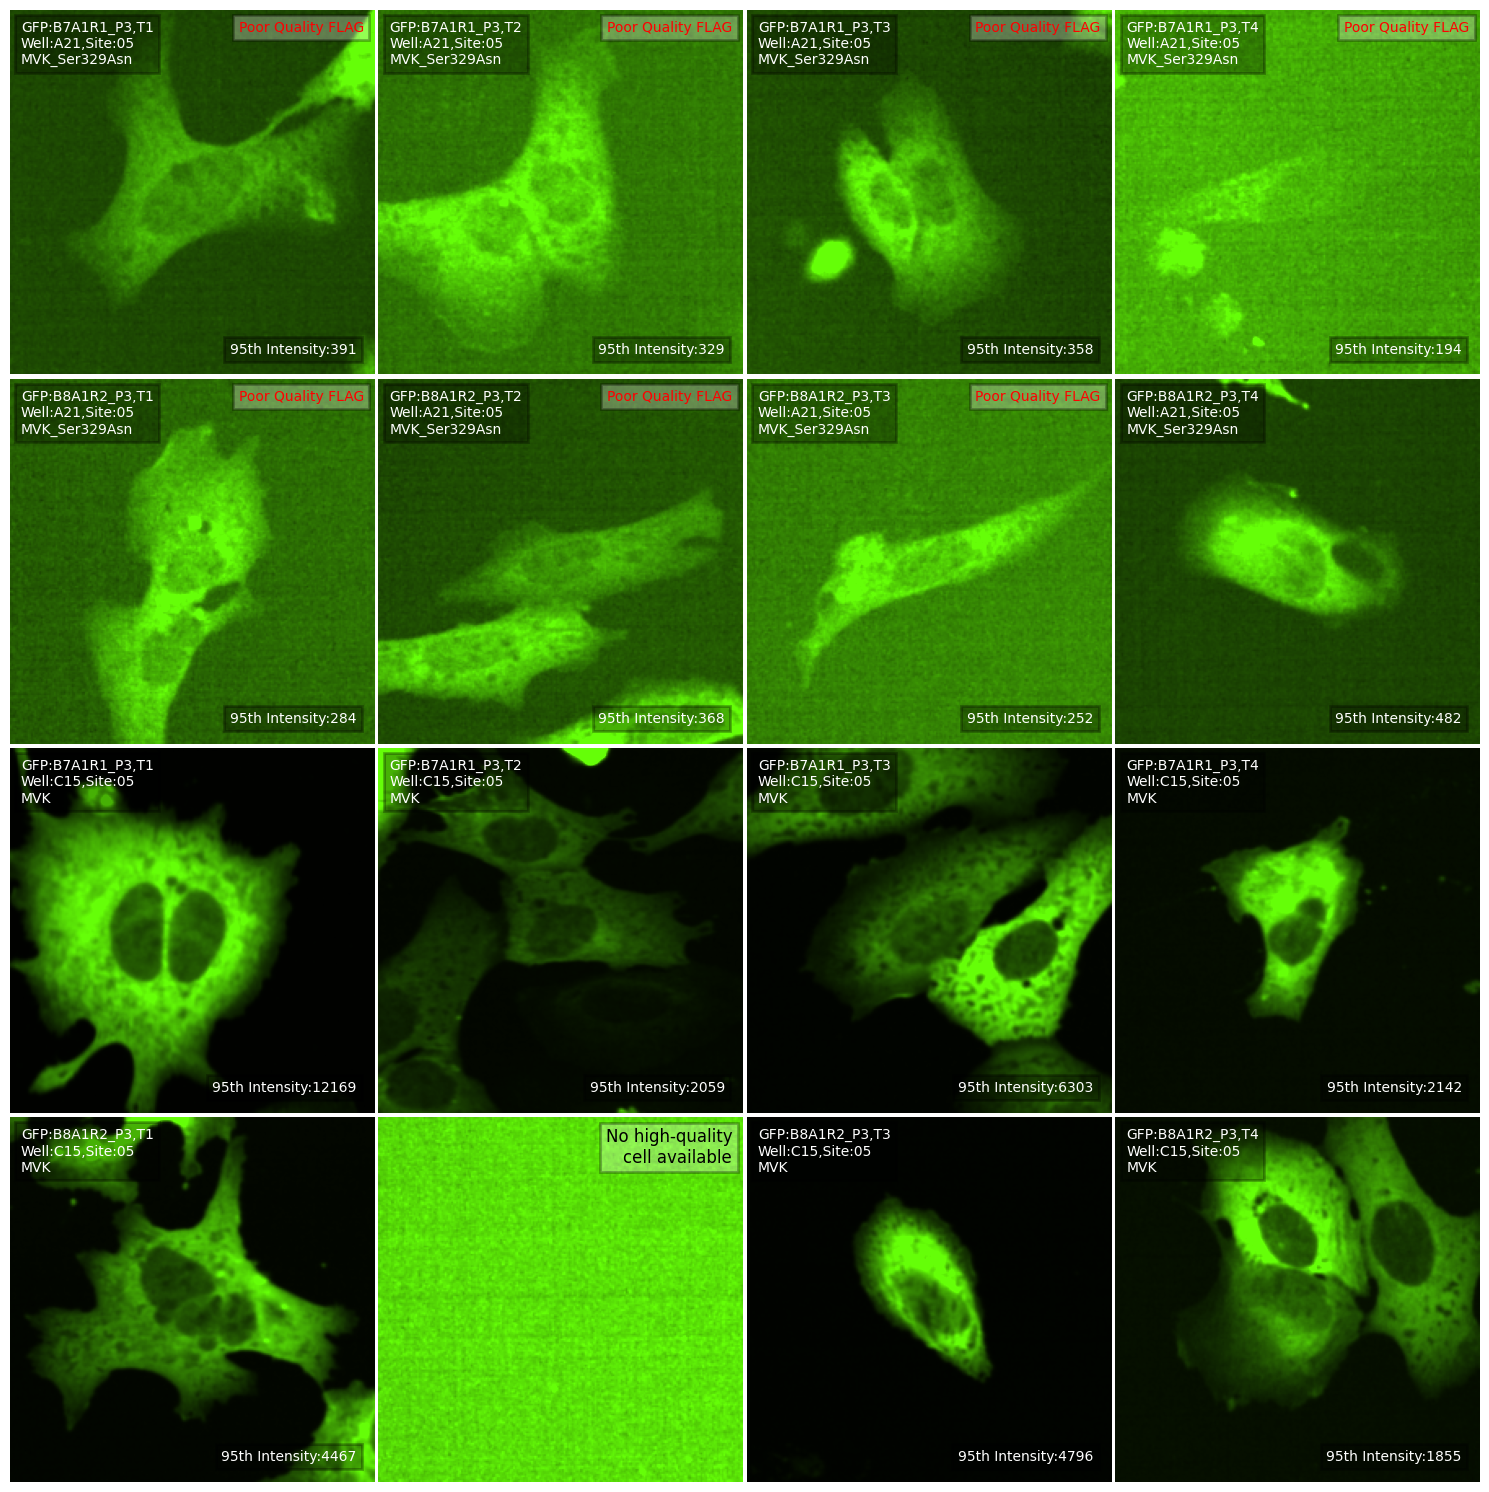

In [71]:
plot_allele_cell(allele_meta_df_dict[bio_rep], 
                 variant="MVK_Ser329Asn", sel_channel=feat, 
                 auroc_df=auroc_df_dict[bio_rep][feat], 
                 plate_img_qc=img_well_qc_sum_dict[bio_rep], 
                 site="05", max_intensity=0.99, display=True, 
                 imgs_dir=TIFF_IMGS_DIR, output_dir="")